## Tutorials: Contact Probability Computation

### Import the necessary packages

In [1]:
import sys
import numpy as np
import sklearn.cluster as sk
import matplotlib.pyplot as plt
import copy
import subprocess
import scipy.stats
import matplotlib.patches as mpatches
import matplotlib as mpl
import warnings
import MDAnalysis as mda
from openNucleome.utils import DamID_TSASeq_calculation
warnings.filterwarnings("ignore")

mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.size'] = 22

### Compute the simulated DamID and TSASeq

In the next step, we calculated the DamID and TSASeq with the function "openNucleome.utils.DamID_TSASeq_calculation" and the trajectory "OpenNucleome/tutorials/HFF_100KB/SphericalNucleus
/LangevinDynamics/reduced_traj.dcd", which contains 50 frames totally

In [2]:
### DamID_TSASeq_calculation(traj_data, gLength, maternalIdx, paternalIdx, start_frame, end_frame)

# gLengthFile.txt: The difference between each two neighboring values in the file represents the length of the chromosome
# maternalIdxFile.txt: Index of each maternal chromosome
# paternalIdxFile.txt: Index of each paternal chromosome

### See more details on https://zhanggroup-mitchemistry.github.io/OpenNucleome/OpenNucleome.html#opennucleome-utils-damid-tsaseq-calculation

damid_simulated, tsaseq_simulated, n_clusters = DamID_TSASeq_calculation("reduced_traj.dcd", "mol_info/gLengthFile.txt", "mol_info/maternalIdxFile.txt",
                                                                         "mol_info/paternalIdxFile.txt", 0, 50)

In [3]:
# Defined some important variables
N_chr_beads         = 60642            #Number of chromosome particles 

N_nucleolus_particles       = 300      #The number of nucleolus particles
N_speckles_particles        = 1600     #The number of speckle particles
N_lamina_particles          = 8000     #The number of lamina particles
radius_nucleus              = 13.0     #The radius of cell nucleus, 13.0 (LJ unit) = 5.0 µm

"""Info files"""
gLength             = np.loadtxt("mol_info/gLengthFile.txt",dtype=int)      #The difference between each two neighboring values
                                                                            #in the file represents the length of the chromosome
maternalIdx         = np.loadtxt("mol_info/maternalIdxFile.txt",dtype=int)  #Index of each maternal chromosome
paternalIdx         = np.loadtxt("mol_info/paternalIdxFile.txt",dtype=int)  #Index of each paternal chromosome

### Visualization

Comparison between simulated and experimental Lamin-B DamID (top) and SON TSA-Seq signals (bottom)

In [4]:
damid_data_low_res  = np.loadtxt("mol_info/DAM-ID_HFF_100KB.txt",usecols=[1])
tsa_data_low_res    = np.loadtxt("mol_info/TSA-Seq_SON_HFF_100KB.txt",usecols=[1])


chr_choose      = 7
dpi_            = 3000
bin_width_      = 0.8
yaxis_labels    = ["DamID\n(Model)","DamID\n(Expt)","TSA-Seq\n(Model)","TSA-Seq\n(Expt)"]
subplot_dict    = dict({"L":0,"S":2})

x_axis    = np.linspace(0,gLength[chr_choose]-gLength[chr_choose-1]-1,
                        gLength[chr_choose]-gLength[chr_choose-1],dtype=int)
fig1, axs1 = plt.subplots(4,figsize=(9,6.3),sharex=True,gridspec_kw={'height_ratios':[1,1,1,1]},dpi=dpi_)

plt.subplots_adjust(hspace=0)
axs1[0].set_title('Chromosome 7')

damid_data_low_res_chr             = copy.deepcopy(damid_data_low_res[paternalIdx[chr_choose-1][0]-1
                                                                      :paternalIdx[chr_choose-1][1]])
tsa_data_low_res_chr               = copy.deepcopy(tsa_data_low_res[paternalIdx[chr_choose-1][0]-1
                                                                    :paternalIdx[chr_choose-1][1]])
damid_data_low_res_chr_positive    = damid_data_low_res_chr>=0.0
tsa_data_low_res_positive          = tsa_data_low_res_chr>=0.0

for nuclear_body in ["L","S"]:

    if nuclear_body == 'L':
        laf_chr          = damid_simulated[gLength[chr_choose-1]:gLength[chr_choose]]
    else:
        laf_chr          = tsaseq_simulated[gLength[chr_choose-1]:gLength[chr_choose]]

    laf_chr_OE   = (laf_chr/(np.mean(laf_chr[:])))

    log2_laf_chr     = np.zeros(len(laf_chr_OE))
    non_zero_indices = (laf_chr_OE!=0.0)
    log2_laf_chr[non_zero_indices] = np.log2(laf_chr_OE[non_zero_indices])

    enriched_indices = log2_laf_chr>=0.0
    axs1[subplot_dict[nuclear_body]].bar(x_axis[enriched_indices],log2_laf_chr[enriched_indices],
                                             width=bin_width_,color="orange",alpha=0.8)
    axs1[subplot_dict[nuclear_body]].bar(x_axis[~enriched_indices],log2_laf_chr[~enriched_indices],
                                             width=bin_width_,color="blue",alpha=0.8)
    axs1[subplot_dict[nuclear_body]].set_ylim([-2.0,2.0])
    axs1[subplot_dict[nuclear_body]].set_xlim([0,x_axis[-1]])
    axs1[subplot_dict[nuclear_body]].spines['top'].set_linewidth('2.0')
    axs1[subplot_dict[nuclear_body]].spines['right'].set_linewidth('2.0')
    axs1[subplot_dict[nuclear_body]].spines['left'].set_linewidth('2.0')
    axs1[subplot_dict[nuclear_body]].spines['bottom'].set_linewidth('2.0')
    
axs1[1].bar(x_axis[damid_data_low_res_chr_positive],
            damid_data_low_res_chr[damid_data_low_res_chr_positive],color='orange',width=bin_width_,alpha=0.8)
axs1[1].bar(x_axis[~damid_data_low_res_chr_positive],
            damid_data_low_res_chr[~damid_data_low_res_chr_positive],color='blue',width=bin_width_,alpha=0.8)
axs1[1].set_ylim([-2.0,2.0])
axs1[3].bar(x_axis[tsa_data_low_res_positive],
            tsa_data_low_res_chr[tsa_data_low_res_positive],color='orange',width=bin_width_,alpha=0.8)
axs1[3].bar(x_axis[~tsa_data_low_res_positive],
            tsa_data_low_res_chr[~tsa_data_low_res_positive],color='blue',width=bin_width_,alpha=0.8)
axs1[3].set_ylim([-2.0,2.0])
axs1[3].spines['top'].set_linewidth('2.0')
axs1[3].spines['right'].set_linewidth('2.0')
axs1[3].spines['left'].set_linewidth('2.0')
axs1[3].spines['bottom'].set_linewidth('2.0')
axs1[1].spines['top'].set_linewidth('2.0')
axs1[1].spines['right'].set_linewidth('2.0')
axs1[1].spines['left'].set_linewidth('2.0')
axs1[1].spines['bottom'].set_linewidth('2.0')

for i in range(4):
    axs1[i].set_ylabel(yaxis_labels[i],fontsize=22)
axs1[3].set_xlabel("Genomic position (100KB)",fontsize=24)

location_array    = axs1[0].get_position().get_points()
x_legend,y_legend = location_array[0]+0.5*(location_array[1]-location_array[0])

y_legend += 1.5 

plt.tight_layout()
plt.show()
plt.close()

In the above block, we have got the number of speckle clusters (n_clusters), and in the next block, we showed the stationary behavior of the number of speckle clusters. And notice that here we only analyzed one trajectory with 50 frames, so the fluctuation of number is large compared with the Fig. S1.

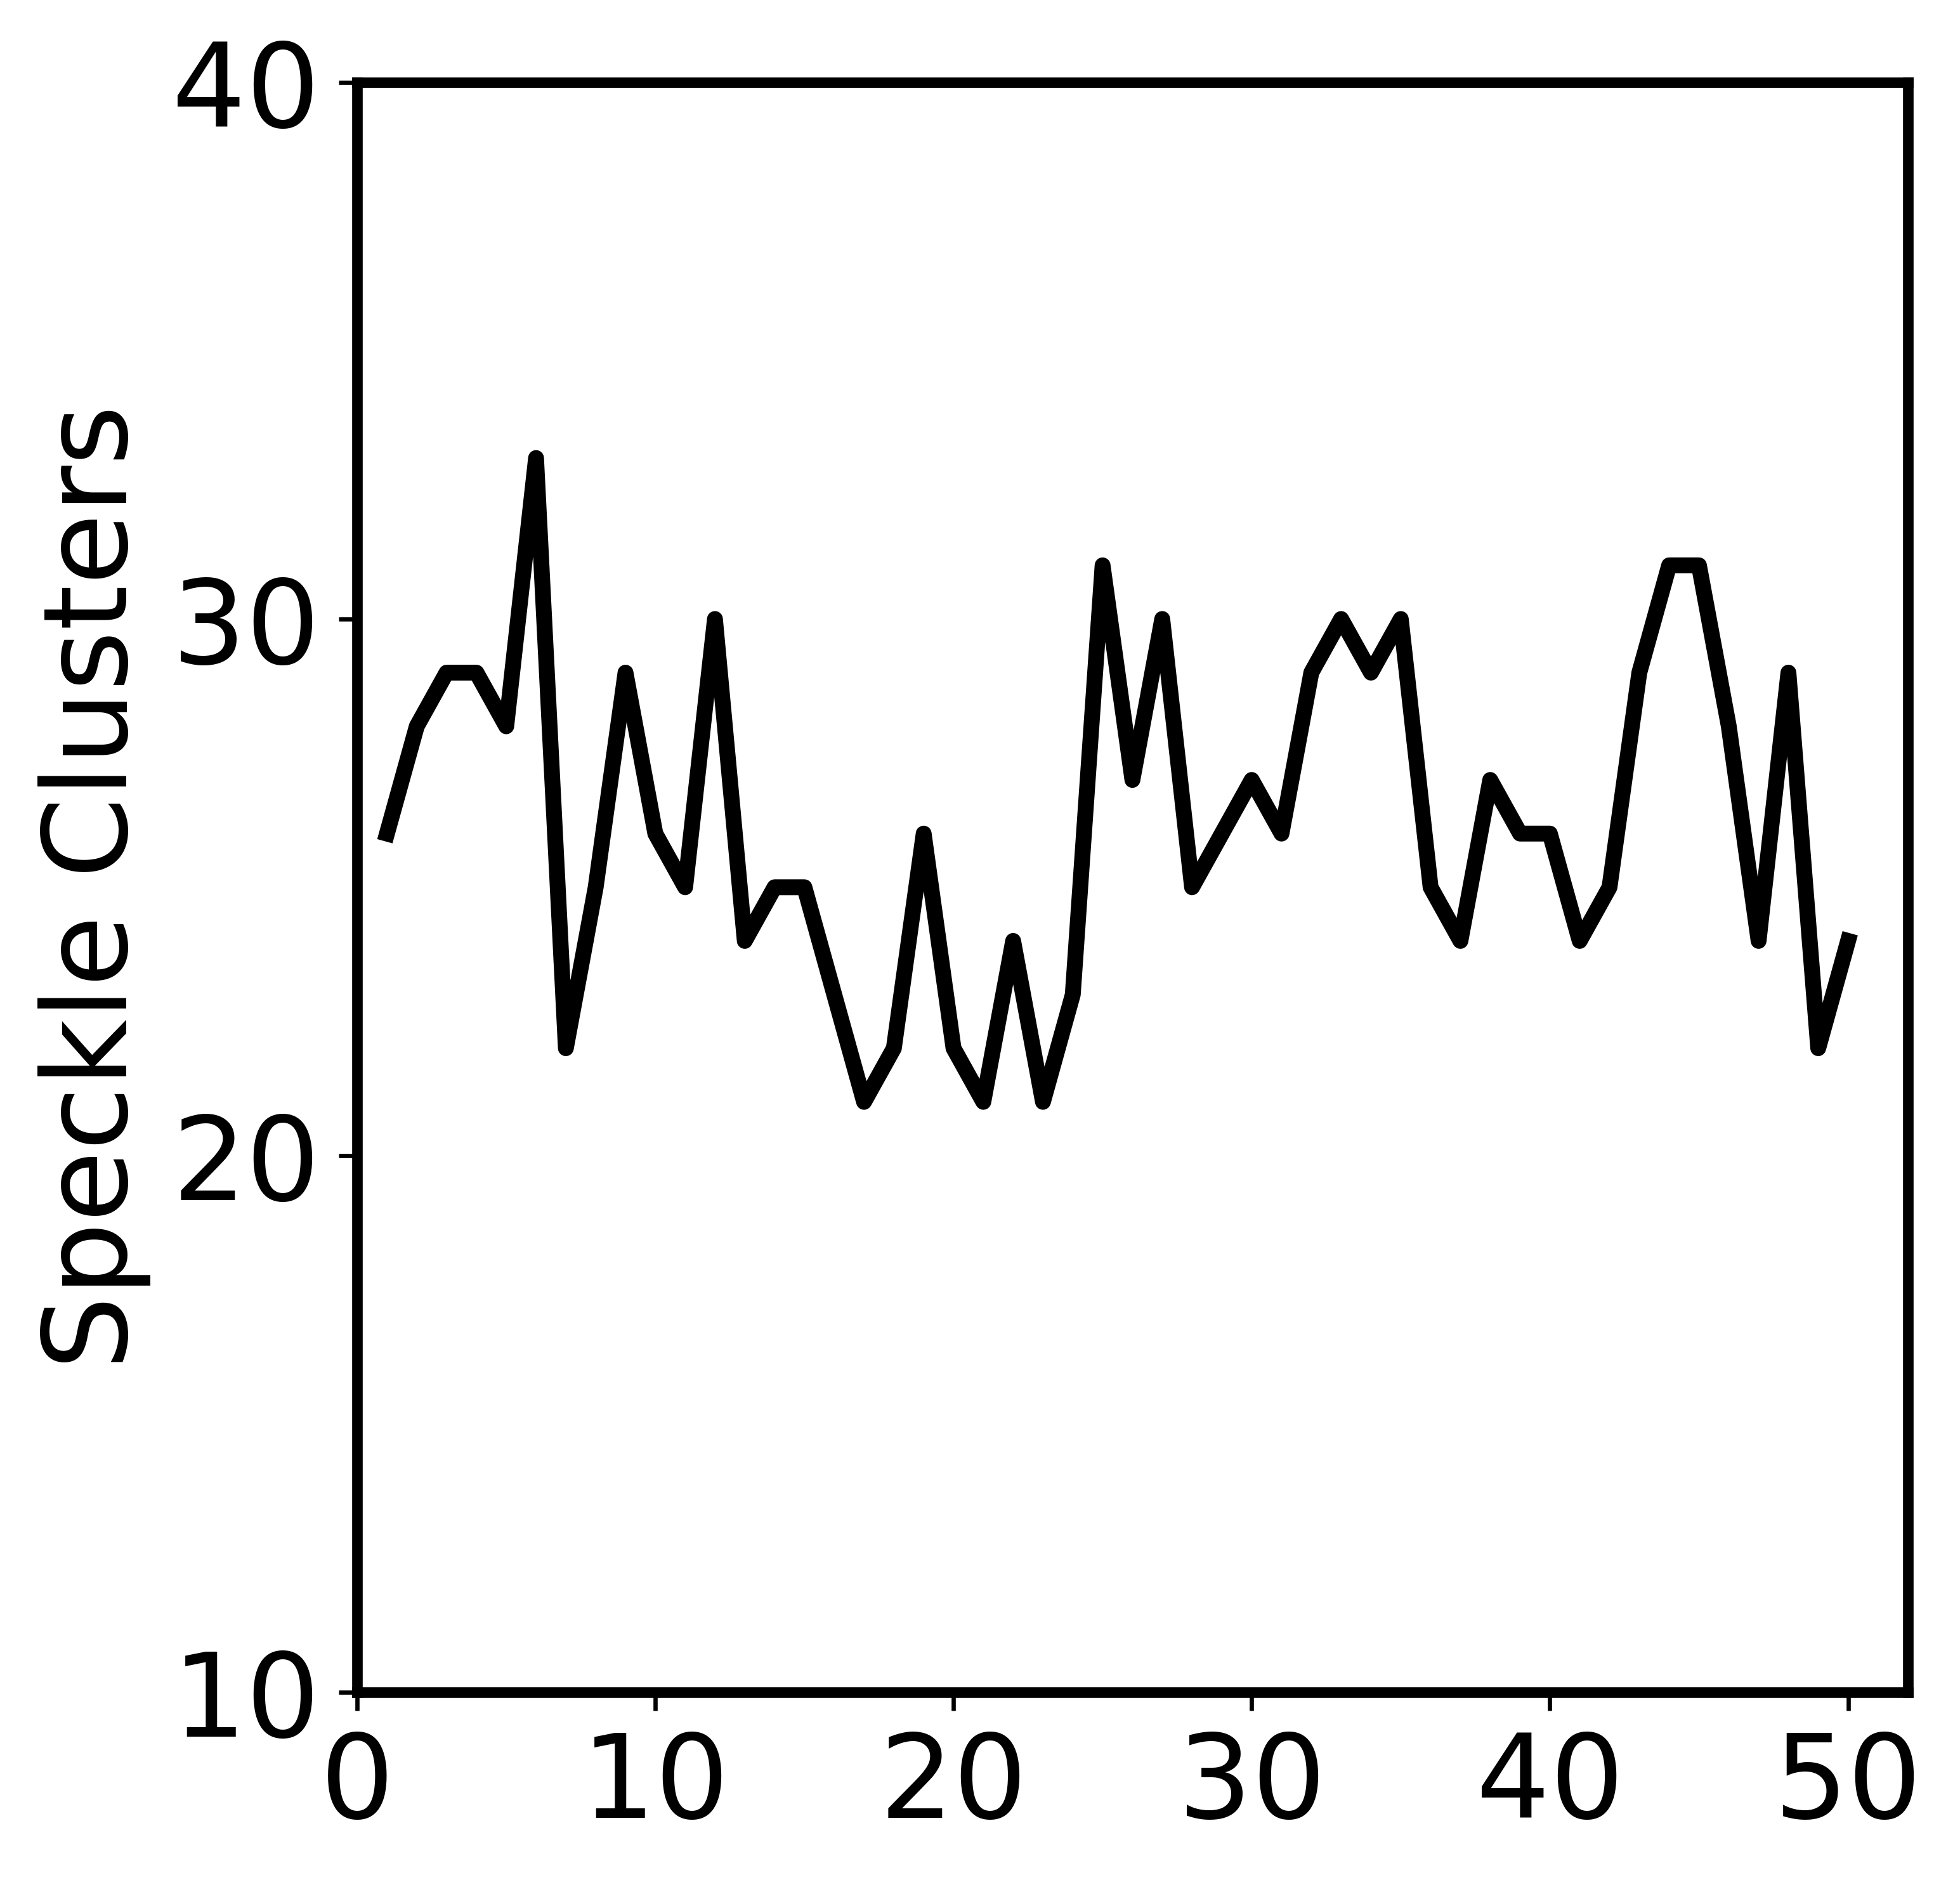

In [5]:
fig=plt.figure(figsize=(5.6,5.4),dpi=600)
plt.plot(np.arange(1, len(n_clusters)+1), n_clusters, c='black', linewidth='3.0')

plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600
ax=plt.gca()
ax.spines['top'].set_linewidth('2.0')
ax.spines['right'].set_linewidth('2.0')
ax.spines['left'].set_linewidth('2.0')
ax.spines['bottom'].set_linewidth('2.0')
plt.ylim(10, 40)
plt.yticks(np.arange(10,45,10), labels=['10','20','30','40'])
plt.xticks(np.arange(0,52,10), labels=['0','10','20','30','40','50'])
plt.xlim(0, 52)

plt.ylabel('Speckle Clusters')
plt.tight_layout()
plt.show()
plt.close()

### Compute the chromosome contact probabilities

We compile the Fortran code "OpenNucleome/openNucleome/utility/chromsome_contact_calculation.f90" and analyzed the chromosome-chromosome contact probabilities in the next several blocks.

In [6]:
subprocess.call(["gfortran -o contact_calculation ../../openNucleome/utils/chromosome_contact_calculation.f90"],
                shell=True,stdout=subprocess.PIPE)

0

In the next block, we ran the Fortran code to compute the ideal, compt-compt, and interchromosomal contact probabilities for 50 frames and output three files ('nframes.txt', 'contact_prob.txt', 'counter.txt'), where 'nframes.txt' logs the number of analyzed frames, 'contact_prob.txt' logs averaged contact probabilities over different frames, and 'counter.txt' logs the total number of contacts.

In [7]:
# contact_calculation: execution file compiled from Fortran code
# reduced_traj.dcd: trajectory file
# 1, 50: the analysis starts from 1st frame and ends at 50th frame
# ./contact_prob: save the output in this path
subprocess.call(["./contact_calculation reduced_traj.dcd 1 50 ./contact_prob/"],
                shell=True,stdout=subprocess.PIPE)

0

We plotted the ideal contact probabilities against experimental results in the next block. Again, this analysis is just an example, so the result will be slightly different from the results in the paper.

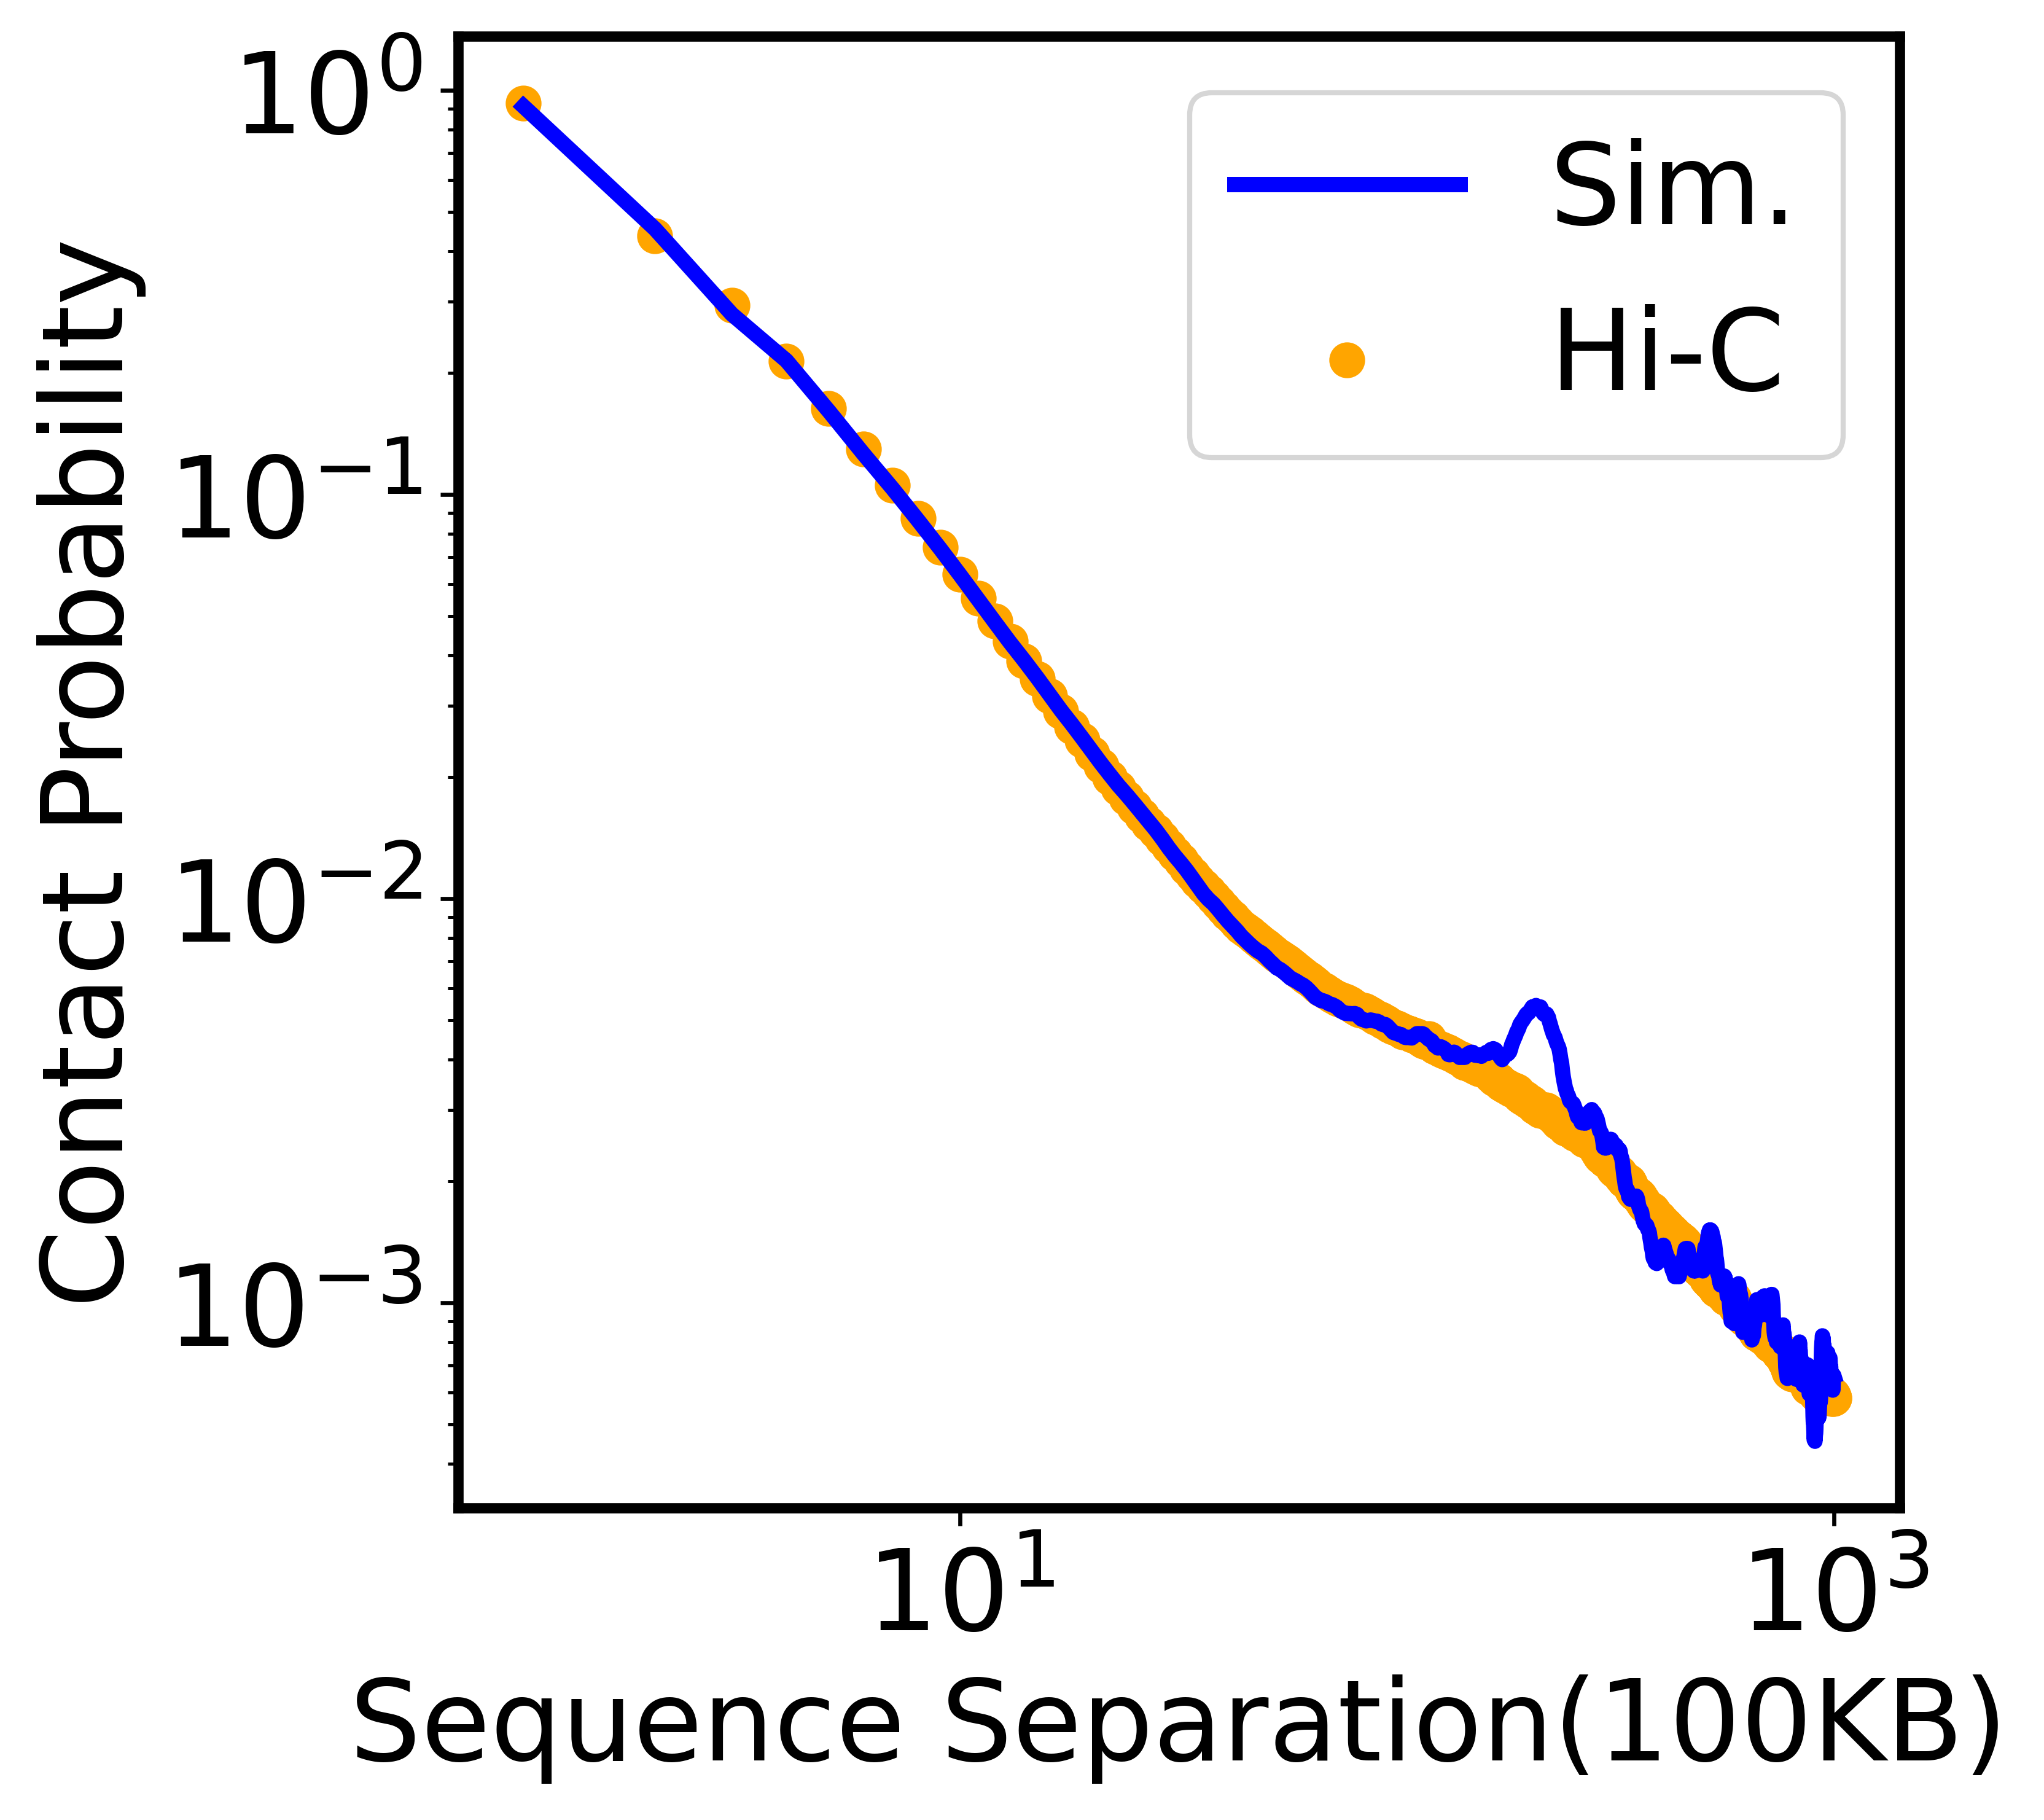

In [8]:
experiment = np.loadtxt('./mol_info/expt_constraints_HFF_100KB.txt')
model = np.loadtxt('./contact_prob/contact_prob.txt')

xaxis = np.arange(1,1001,1)

cutoff_ideal = 1000

fig=plt.figure(figsize=(4.7/4.4*5.4,5.4),dpi=600)

plt.scatter(xaxis, experiment[:cutoff_ideal], c='orange',marker='o', label="Hi-C")
plt.plot(xaxis, model[:cutoff_ideal], c='blue', linewidth='3.0', label="Sim.")
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600
ax=plt.gca()
ax.spines['top'].set_linewidth('2.0')
ax.spines['right'].set_linewidth('2.0')
ax.spines['left'].set_linewidth('2.0')
ax.spines['bottom'].set_linewidth('2.0')
plt.xlabel('Sequence Separation(100KB)')
plt.ylabel('Contact Probability')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

We plotted the compt-compt contact probabilities against experimental results in the next block.

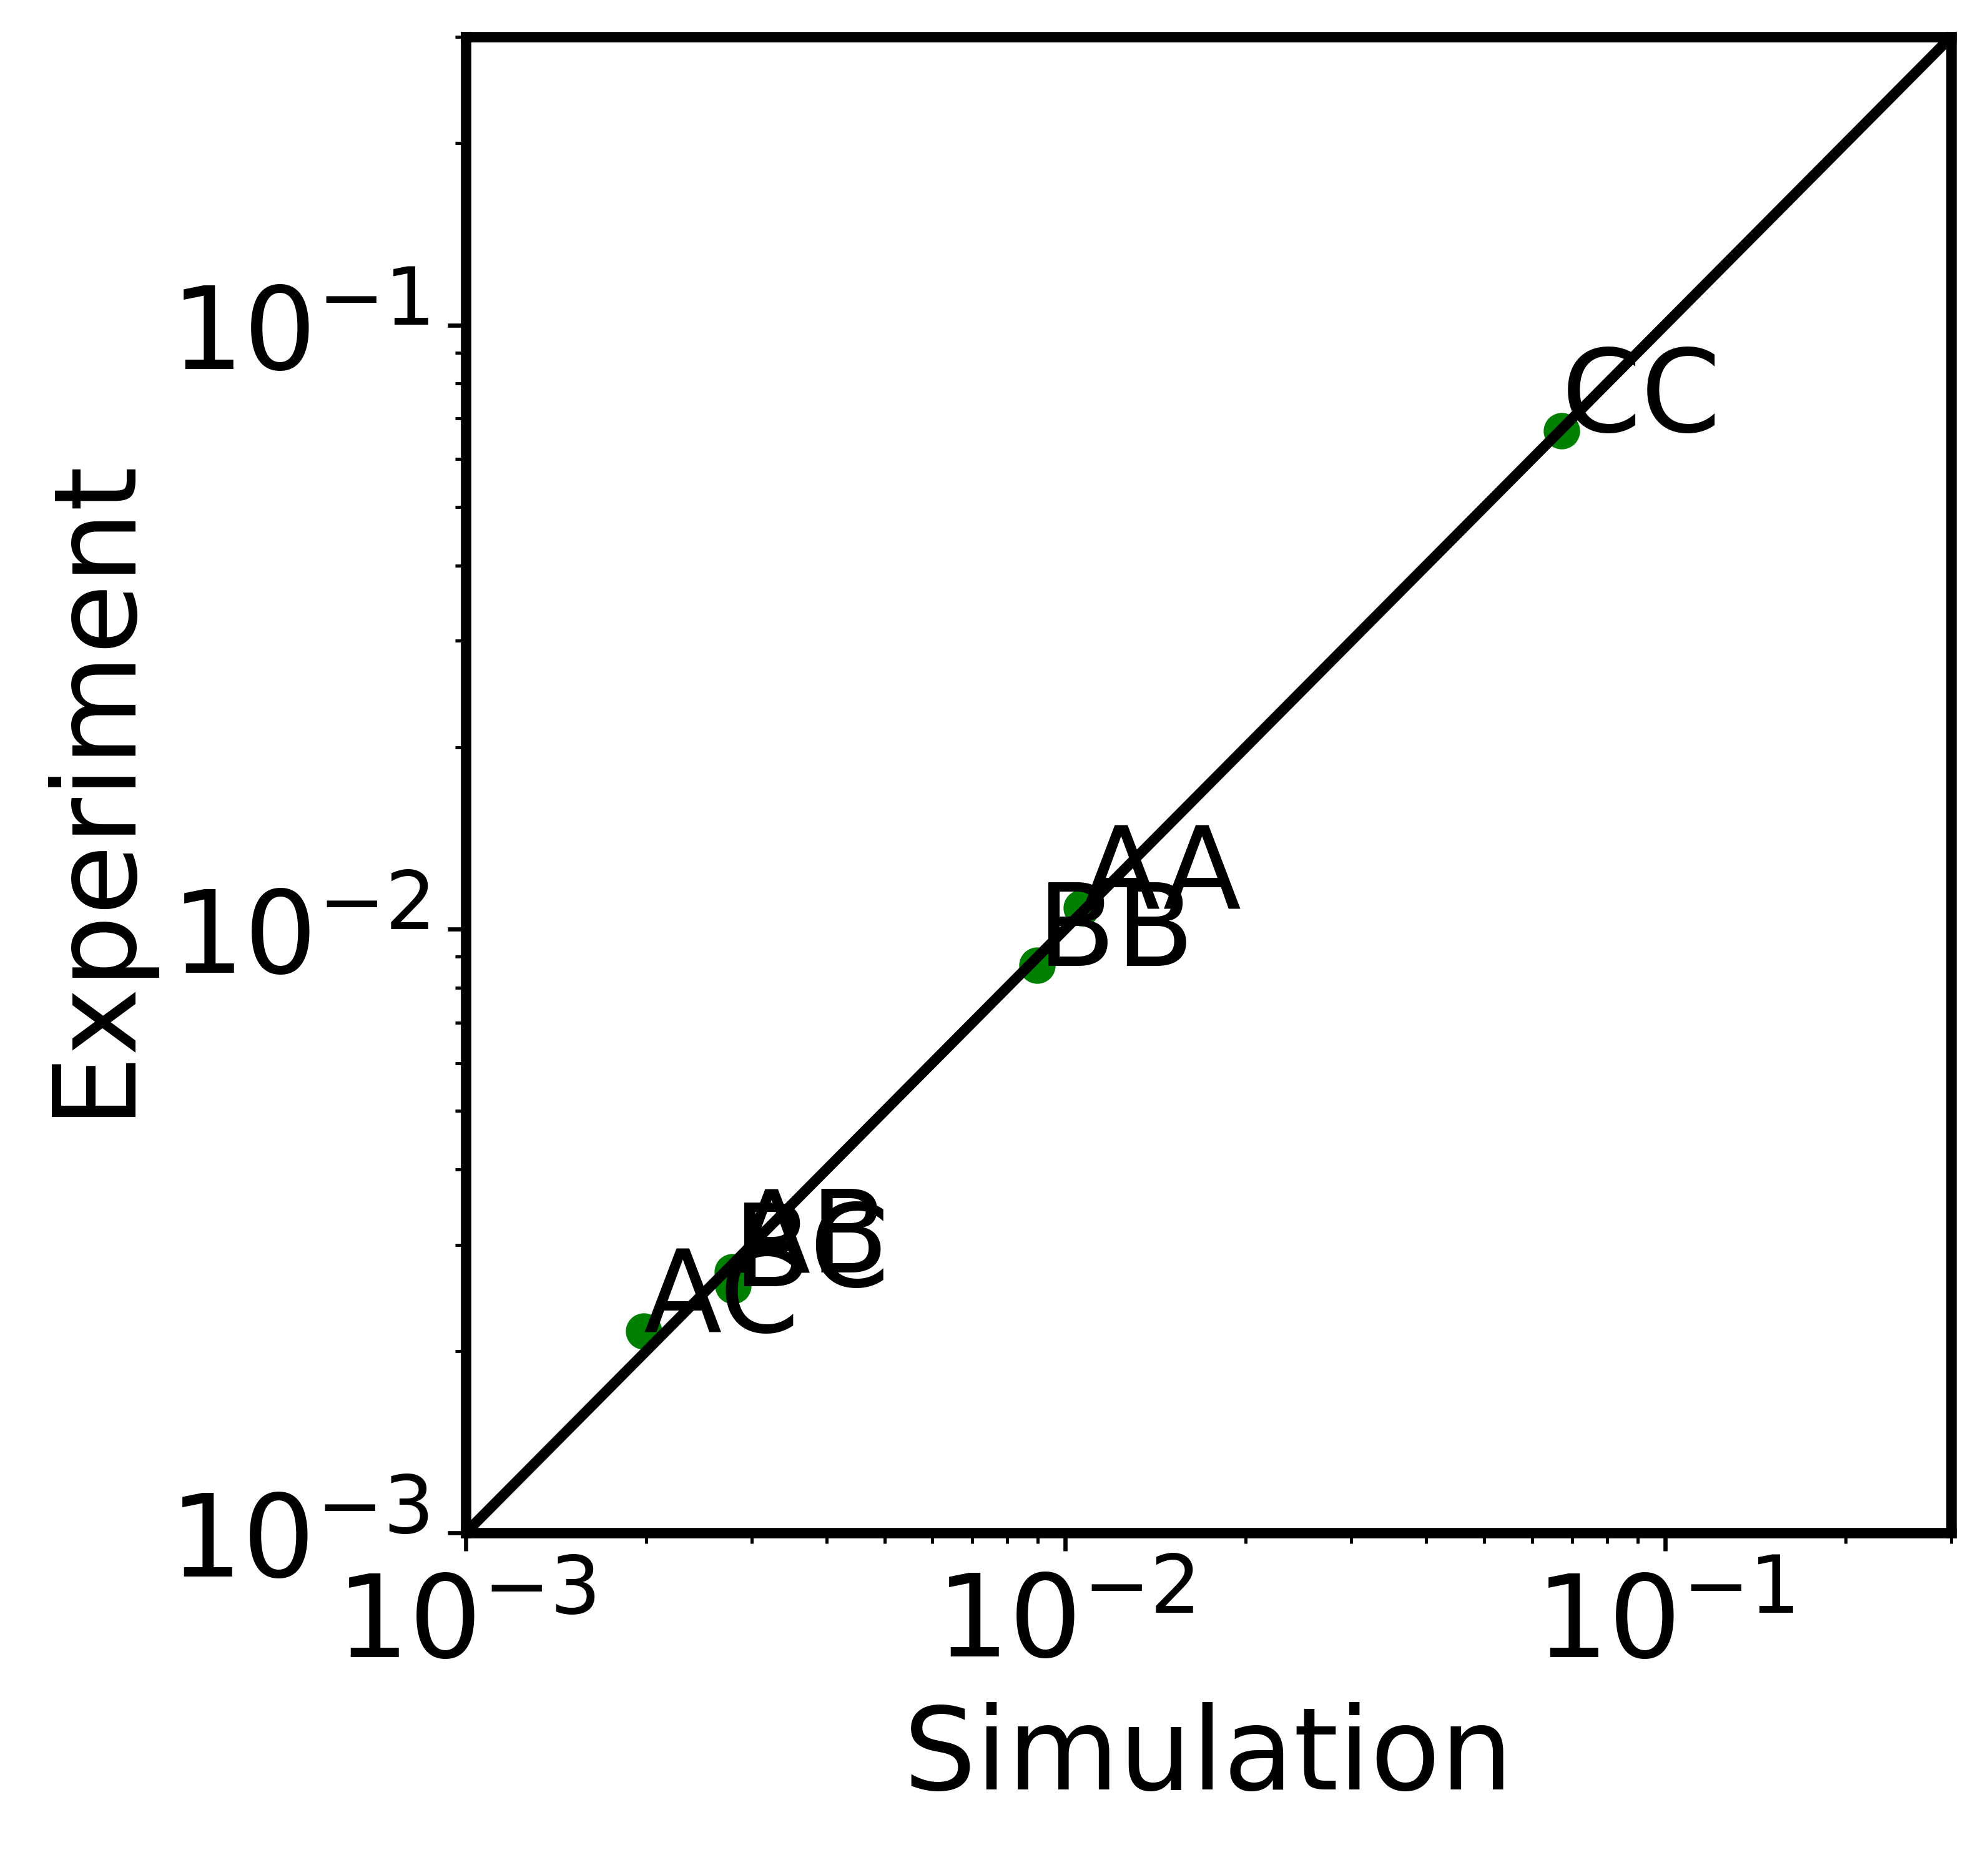

In [9]:
#from adjustText import adjust_text

Label = ['AA', 'AB', 'AC', 'BB', 'BC', 'CC']

line_lim = np.linspace(10**-3, 3*10**-1, num=1000, endpoint=True)

start_cv_compt = 2489
end_cv_compt = 2495

fig=plt.figure(figsize=(4.7/4.4*5.4,5.4),dpi=600)
plt.scatter(model[start_cv_compt:end_cv_compt], experiment[start_cv_compt:end_cv_compt], c='green')
plt.plot(line_lim,line_lim, color='black', linewidth='2.0')
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600
ax=plt.gca()
ax.spines['top'].set_linewidth('2.0')
ax.spines['right'].set_linewidth('2.0')
ax.spines['left'].set_linewidth('2.0')
ax.spines['bottom'].set_linewidth('2.0')
plt.xlim(10**-3, 3*10**-1)
plt.ylim(10**-3, 3*10**-1)
plt.xlabel('Simulation')
plt.ylabel('Experiment')
plt.xscale('log')
plt.yscale('log')
texts = []
for i, label in enumerate(Label):
    texts.append(plt.text(model[start_cv_compt+i],experiment[start_cv_compt+i],label))
#adjust_text(texts, only_move={'points':'y', 'texts':'y'})
plt.tight_layout()
plt.show()
plt.close()

We plotted the interchromosomal contact probabilities against experimental results in the next block.

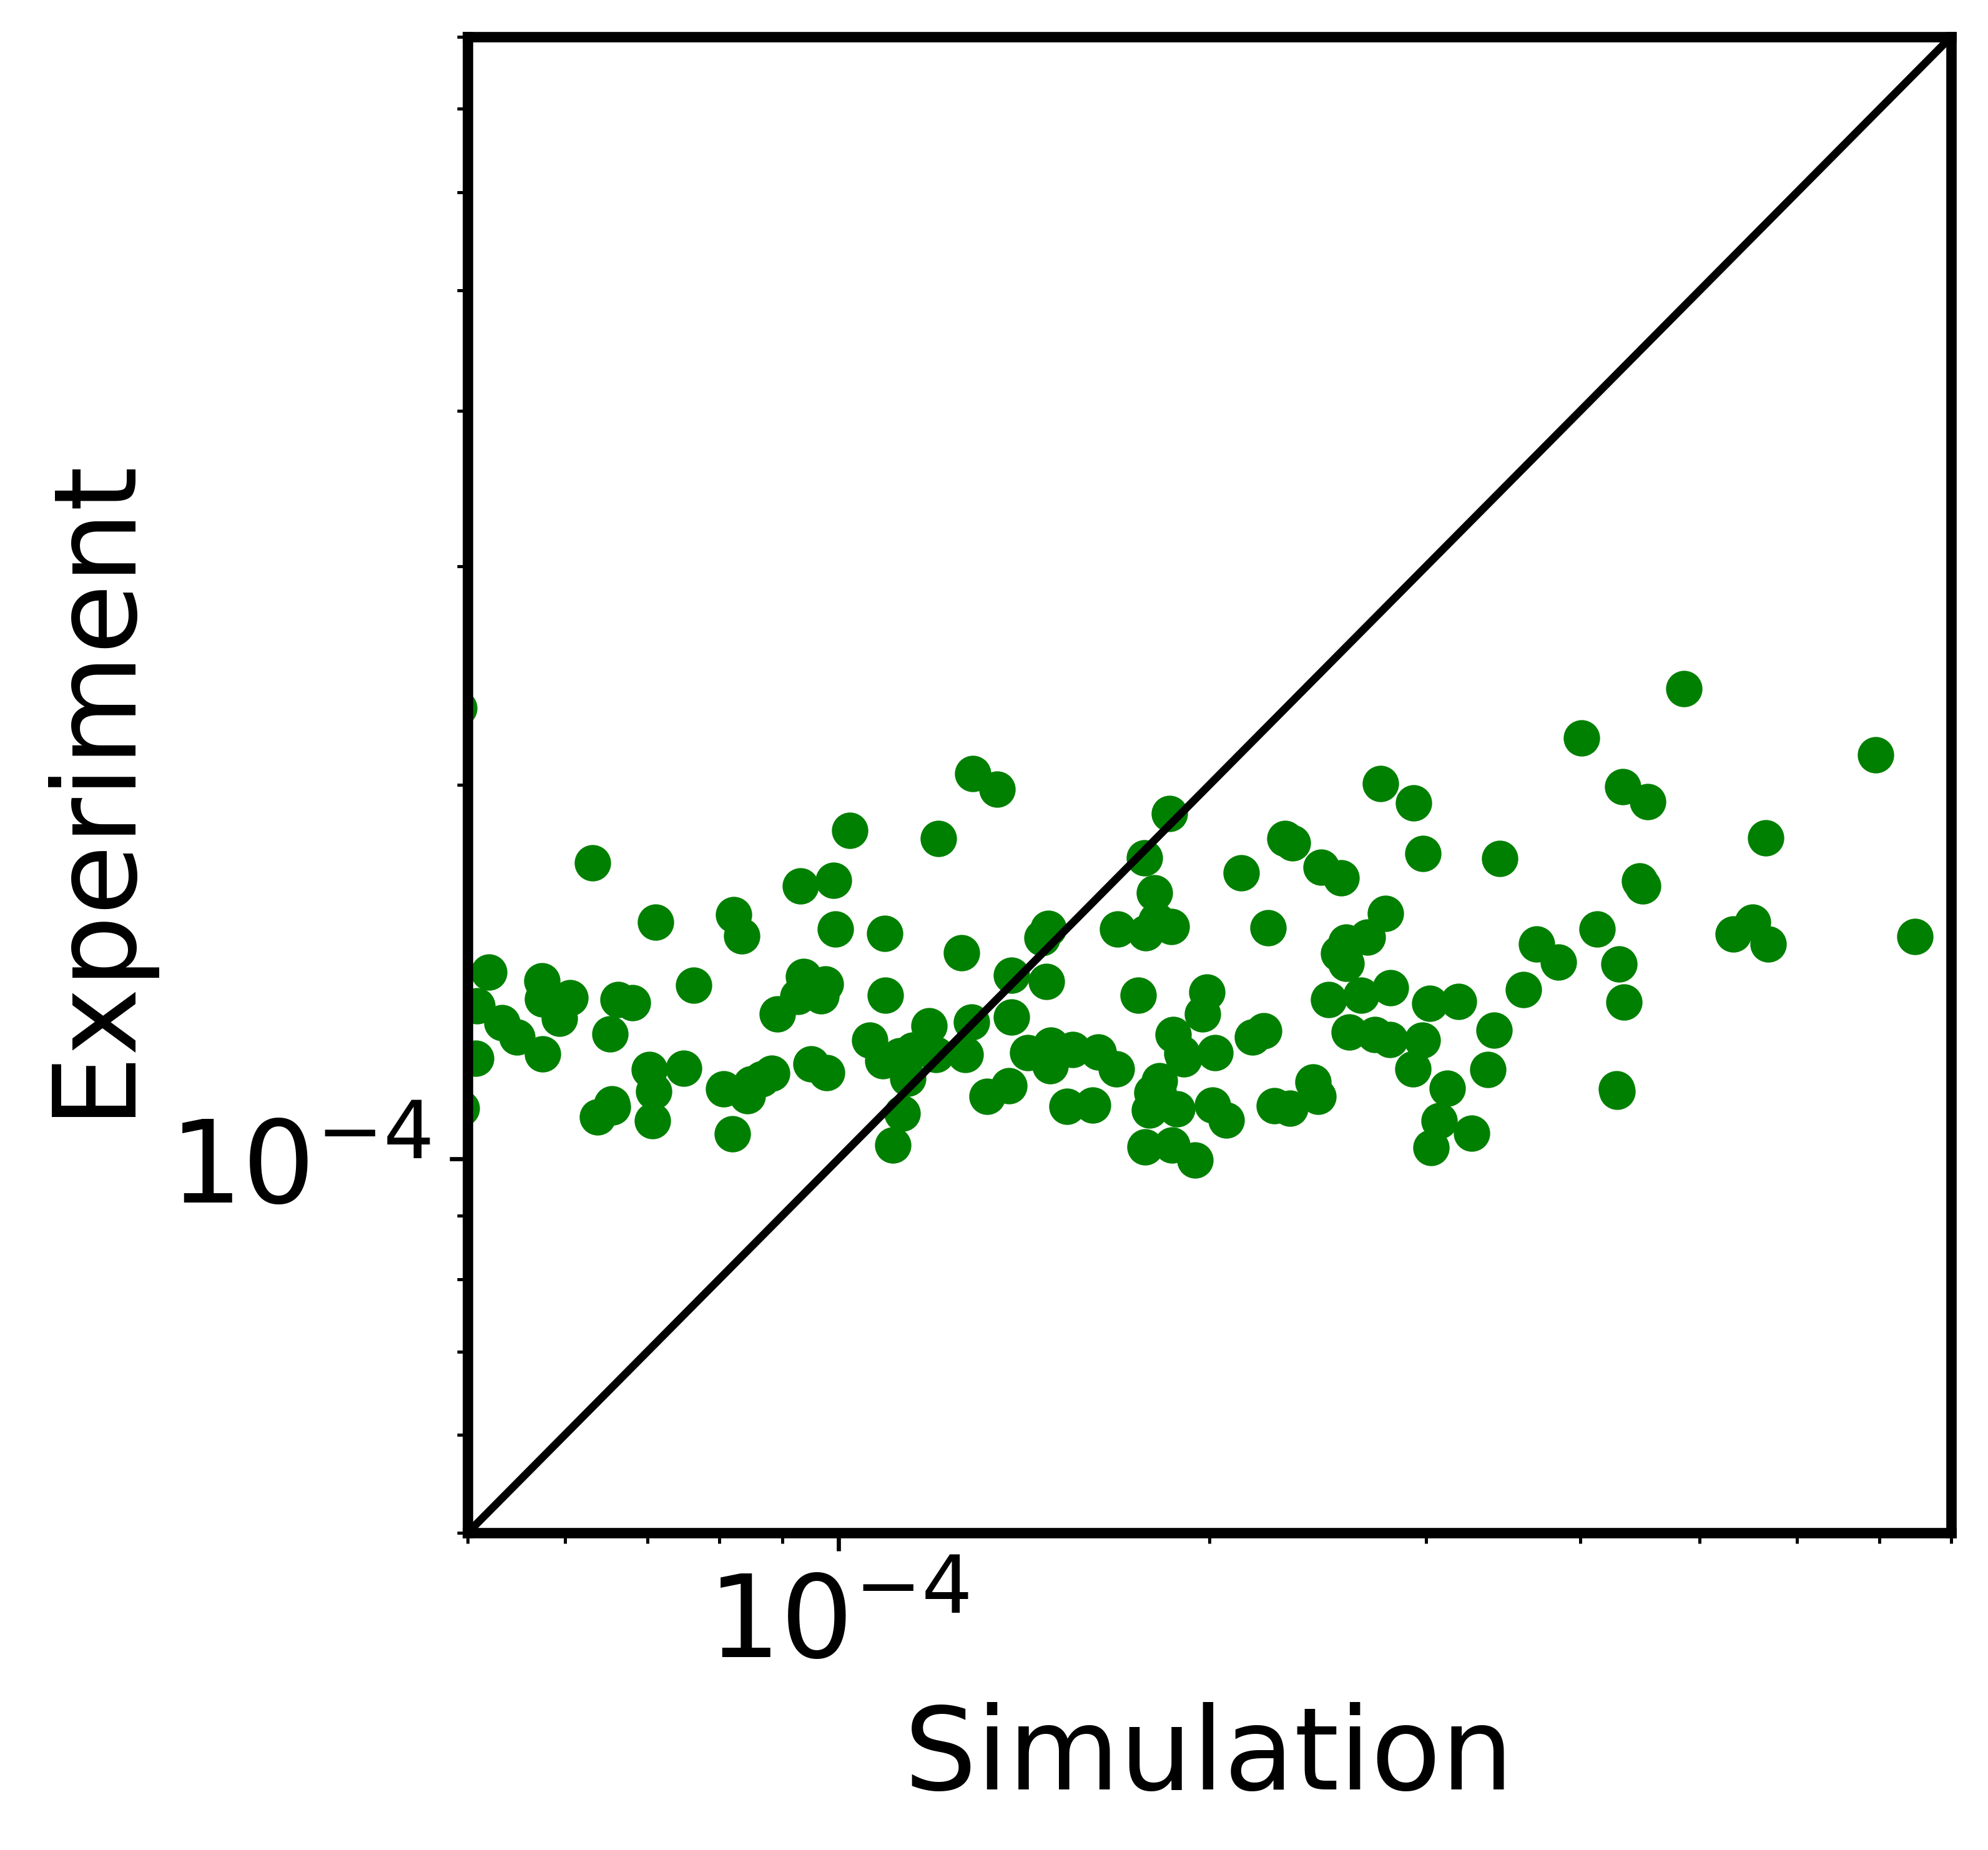

The pearson correlation coefficient is 0.35118148309057723


In [10]:
experiment = model[0]/experiment[0]*experiment

pearson_value = scipy.stats.pearsonr(model[end_cv_compt:], experiment[end_cv_compt:])[0]

line_lim = np.linspace(5*10**-5, 8*10**-4, num=1000, endpoint=True)

fig=plt.figure(figsize=(4.7/4.4*5.4,5.4),dpi=600)
plt.scatter(model[end_cv_compt:], experiment[end_cv_compt:], c='green')
plt.plot(line_lim,line_lim, color='black')
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600
ax=plt.gca()
ax.spines['top'].set_linewidth('2.0')
ax.spines['right'].set_linewidth('2.0')
ax.spines['left'].set_linewidth('2.0')
ax.spines['bottom'].set_linewidth('2.0')
plt.xlim(5*10**-5, 8*10**-4)
plt.ylim(5*10**-5, 8*10**-4)
plt.xlabel('Simulation')
plt.ylabel('Experiment')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()
plt.close()

print("The pearson correlation coefficient is", pearson_value)